<a href="https://colab.research.google.com/github/akshita075/Air_Canvas/blob/main/Simple_Parkinson_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'parkinsons-disease-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817523%2F1399417%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T133709Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31569474f8021b3ebd6c124f3ee14732b2a2db64a5d6a4f3892a6e09dc253b9b93ed5ebf47c6199183a7cb3f76e23a13de3515c775a1a50293ec382e4c31ab5e9e81f0a0e3c245c9595259197adec81516c2c8fce84a075a67b68221487030ba5e1252750e2225faf355b923358637f640636bba66e60f3bdc7c0e1f1b4f203c60176362da352f7593a6ae97f3a27251e641633eb6ca7b26d584a2477a4479d5a49c292ebadf76678d3937d5803a7e831ed56f59a5c581a413a758a8c2af5cf101c37e93403a7a382a381c732abc8d5ba33280b8fa9360d5434f7ff0c601979c3da7f58abf7f72638e4dee42d39ef8f0f48076e185f8c5c0f77d3ffdb8006722,parkinson-disease-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F907215%2F1538467%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240131%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240131T133709Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2ee8af4cd4cc2418dfb6a26b617dd5f61a8ef89271a6cc40c519e4351496a2235b3f26c01a3dc127d549b30ea3bfb0d8d0040830f5d8f68826fee00dbca0b763353ae004441bf18e5aed34557a85616a68ac48f18aef73d98ef1344532dca50e823b4a44a4303c75dbde4020ec0eeba9f2810f6e53b541eb704146377923291b8215daed1a1fcd530e612acc6dc7898b9c7b54e15be0731fd81e49423cffd181c2fa9bfe453d9505ba66f0901ce794779dd8f8cefd621b74f8d7d3cc9e10326474226bc255b613bc8c04d5701a812452f66ddcf6f6c77e941a11433c6e6ea9625f91a0b140f8e3ecae954149ae5b5bc7fafbbf059293d58cc7c2b371c6daf415'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15988 bytes downloaded
Downloaded and uncompressed: parkinsons-disease-data-set
[==================================================] 15179 bytes downloaded
Downloaded and uncompressed: parkinson-disease-detection
Data source import complete.


# Prepare Data

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/parkinsons-disease-data-set/parkinsons.data
/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv


## Import Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv')

In [5]:
print(df.shape)
print(df.info())
df.head()

(195, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Statistical Summary

In [6]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


## Missing values

In [7]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

## Drop name column

In [8]:
df.drop(columns='name',inplace=True)

## Histgram

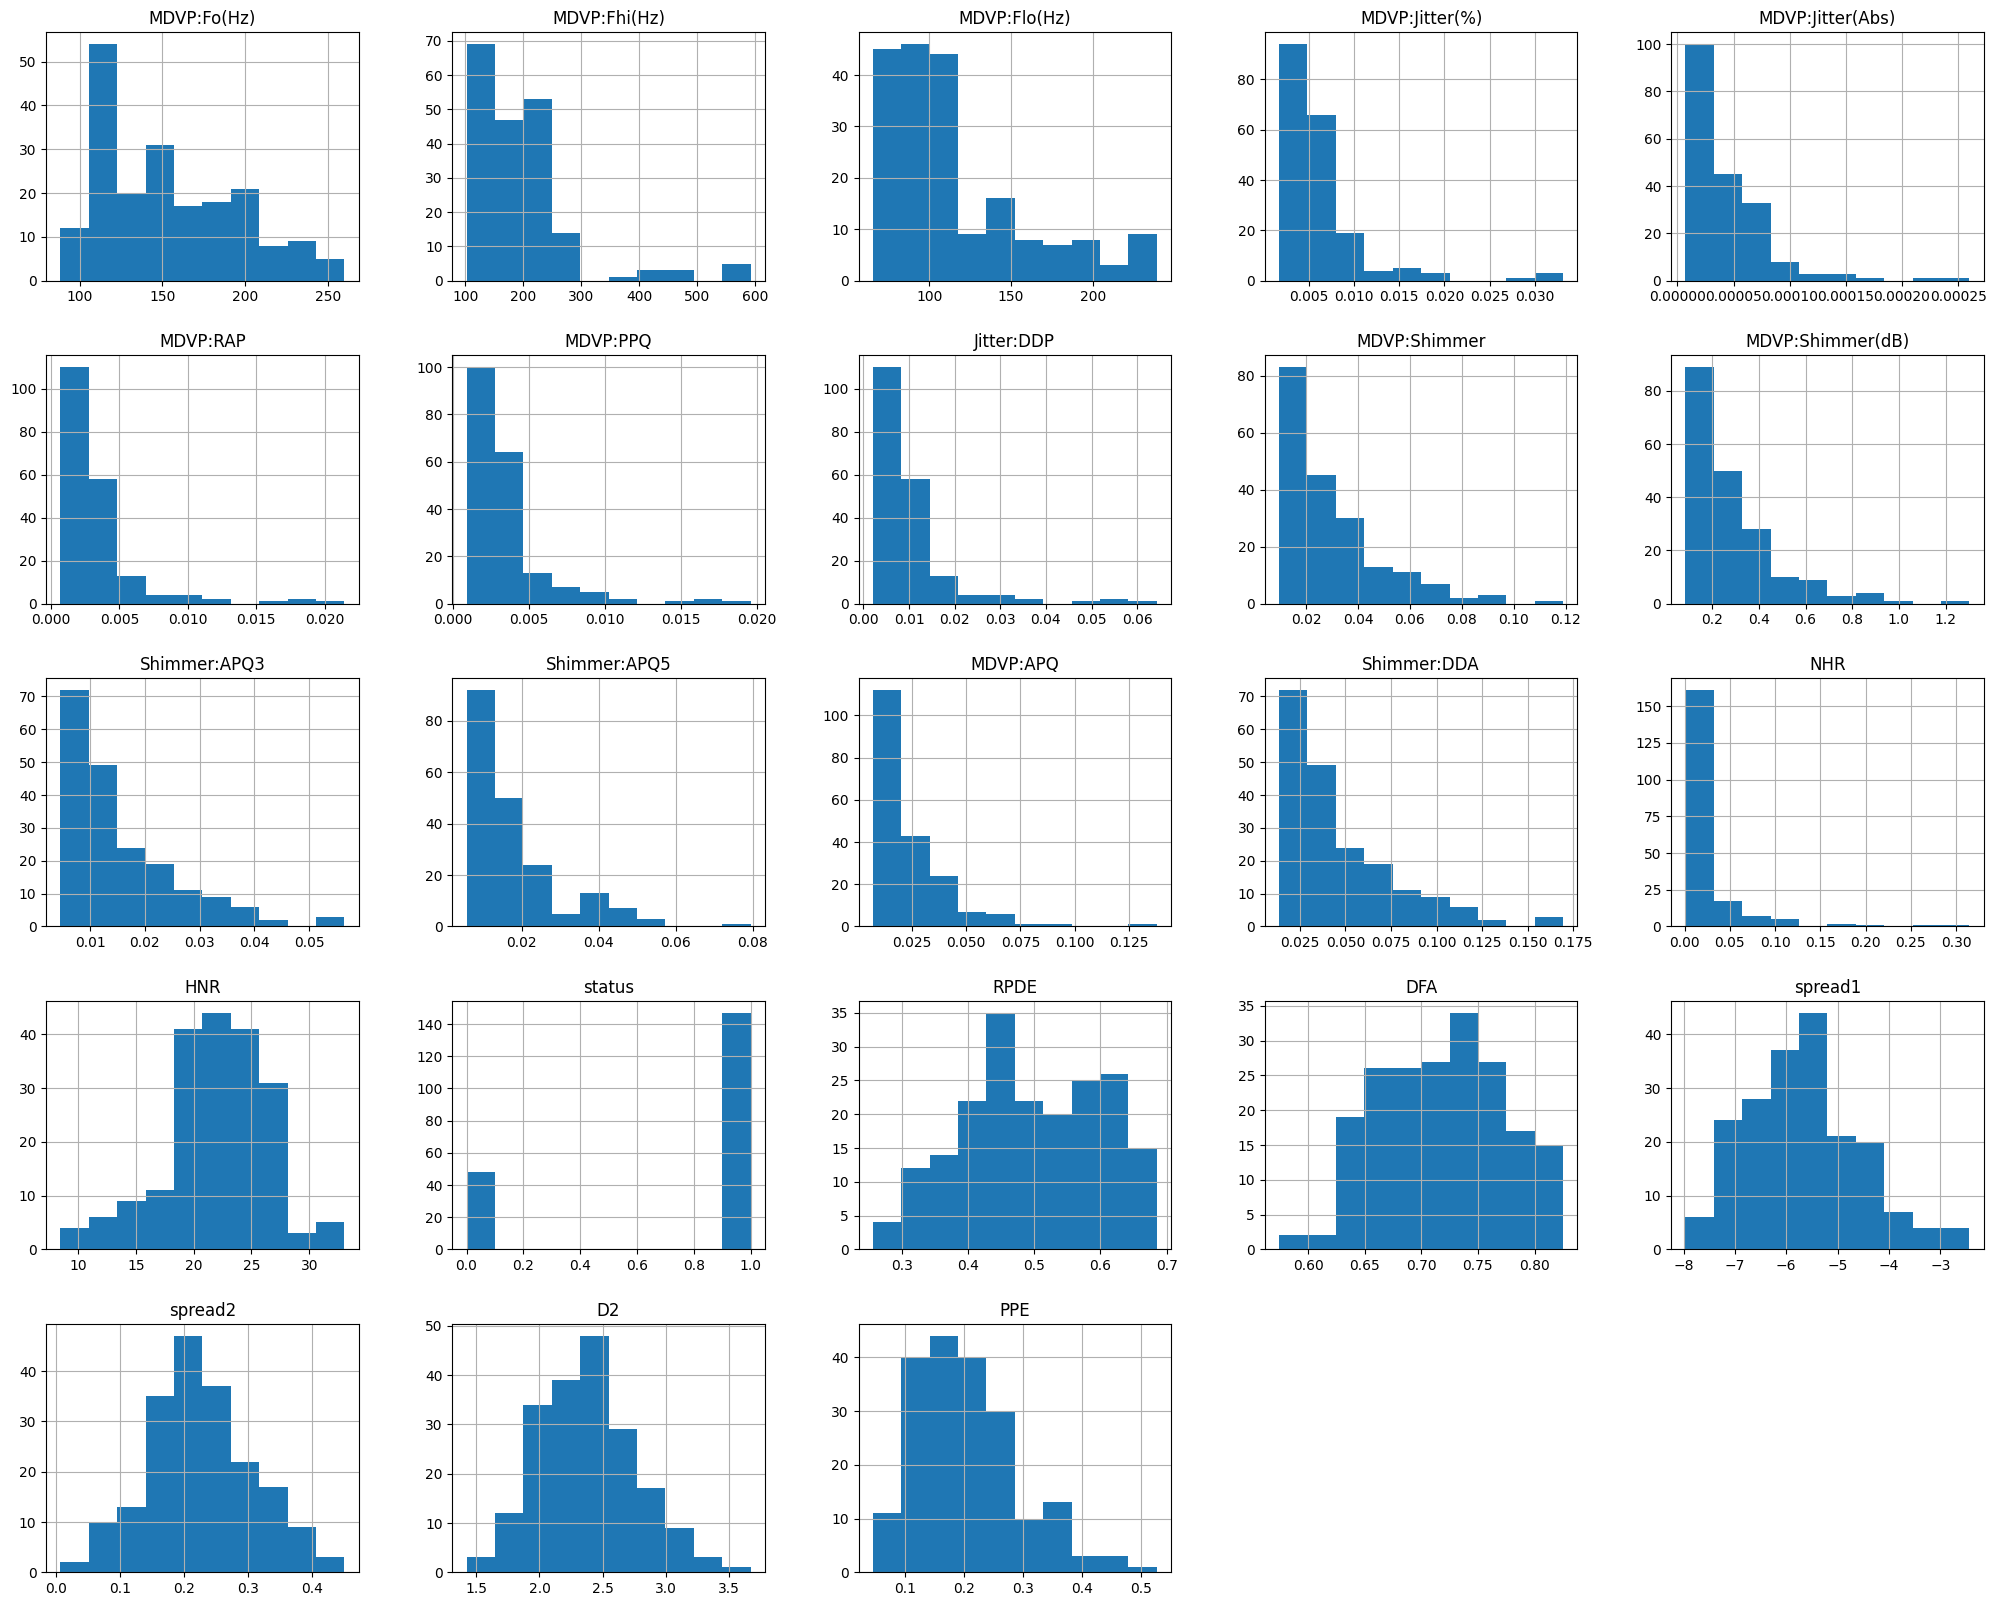

In [9]:
df.hist(figsize=(25,20));

## Check multicorrelation

In [10]:
df.skew()

MDVP:Fo(Hz)         0.591737
MDVP:Fhi(Hz)        2.542146
MDVP:Flo(Hz)        1.217350
MDVP:Jitter(%)      3.084946
MDVP:Jitter(Abs)    2.649071
MDVP:RAP            3.360708
MDVP:PPQ            3.073892
Jitter:DDP          3.362058
MDVP:Shimmer        1.666480
MDVP:Shimmer(dB)    1.999389
Shimmer:APQ3        1.580576
Shimmer:APQ5        1.798697
MDVP:APQ            2.618047
Shimmer:DDA         1.580618
NHR                 4.220709
HNR                -0.514317
status             -1.187727
RPDE               -0.143402
DFA                -0.033214
spread1             0.432139
spread2             0.144430
D2                  0.430384
PPE                 0.797491
dtype: float64

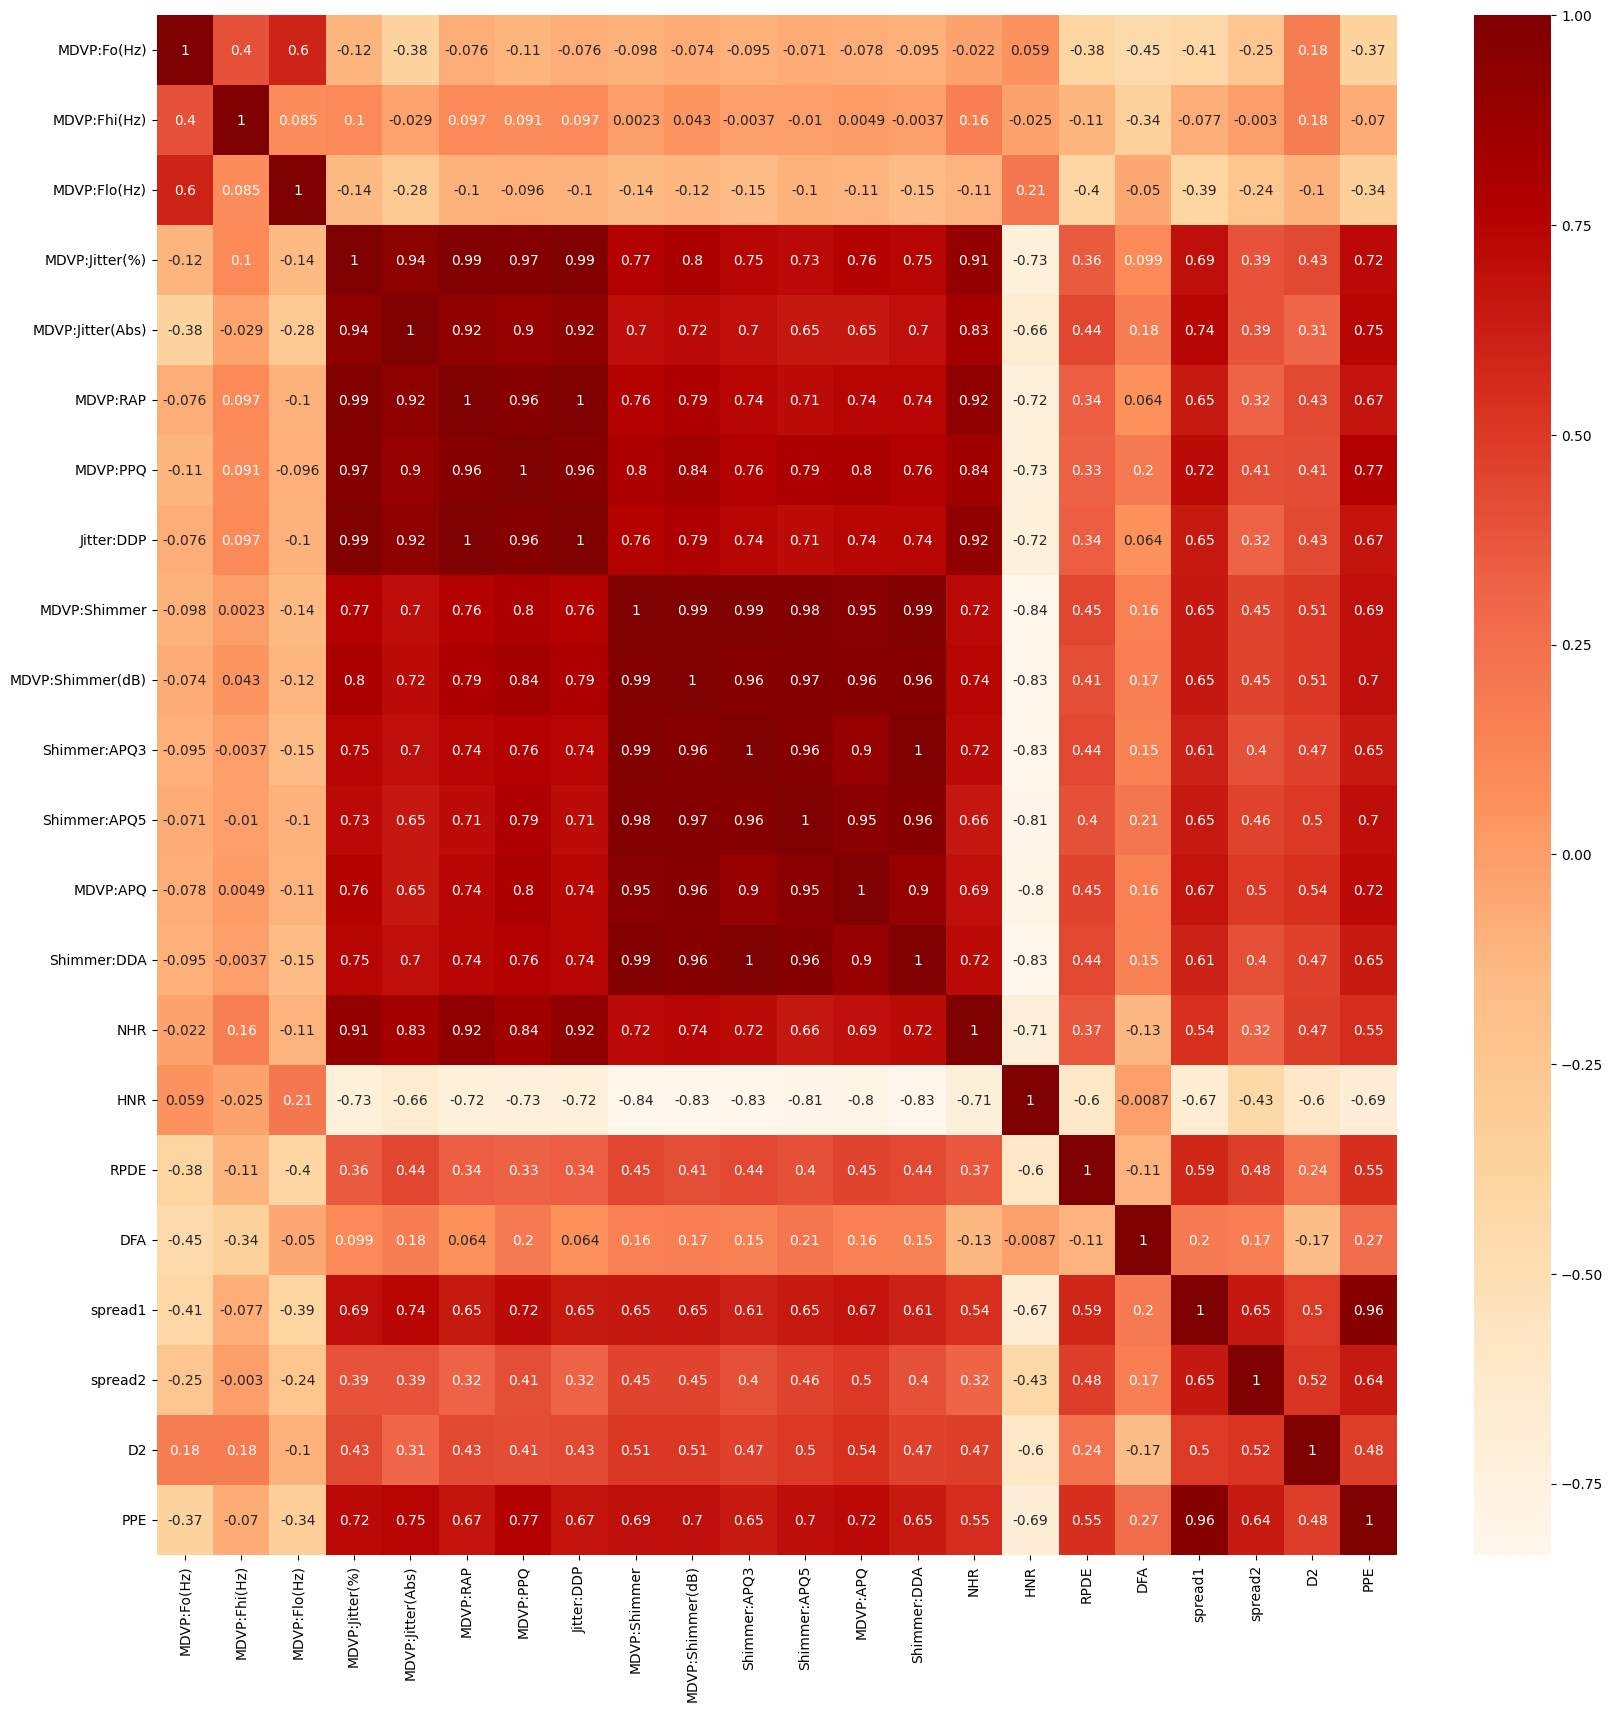

In [11]:
correl=df.drop(columns='status').corr()
plt.figure(figsize=(20,20))
sns.heatmap(correl,annot=True,cmap='OrRd')
plt.show()

# Build model

## Split data

In [12]:
X = df.drop(columns='status')
y=df['status']

In [13]:
#Scale the features to between -1 and 1
scaler=MinMaxScaler((-1,1))
X=scaler.fit_transform(X)
y=y

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(156, 22)
(156,)
(39, 22)
(39,)


## Baseline model

In [15]:
score_baseline = y.value_counts(normalize=True).max()
score_baseline

0.7538461538461538

## LogisticRegression

In [16]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [17]:
pred_lr=lr.predict(X_test)
# get accuracy score
score_lr = accuracy_score(y_test, pred_lr)
print(f'Accuracy Score : {score_lr}')
print(f'Recall Score : {recall_score(y_test,pred_lr)}')


Accuracy Score : 0.8974358974358975
Recall Score : 1.0


##  Confusion Matrix

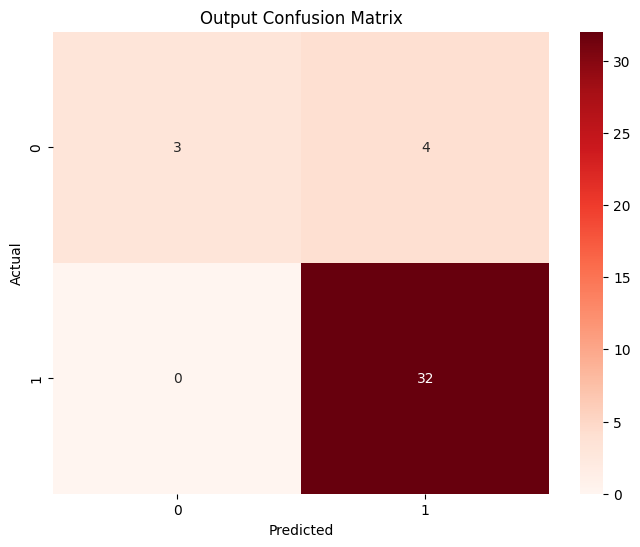

In [18]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred_lr)
plt.figure(figsize=(8,6))
fg=sns.heatmap(cm,annot=True,cmap="Reds")
figure=fg.get_figure()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Output Confusion Matrix");

# Comunicate the results

## Prediction vs actual

In [19]:
pd.DataFrame({'actual':y_test,'predict':pred_lr})

,actual,predict
138,1,1
16,1,1
155,1,1
96,1,1
68,1,1
153,1,1
55,1,1
15,1,1
112,1,1
111,1,1


## Feature importances

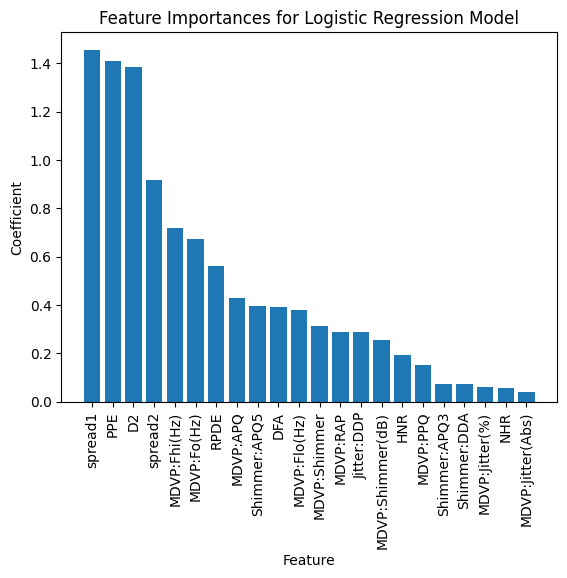

In [20]:
# Get the coefficients of each feature
coef = abs(lr.coef_[0])

# Sort the coefficients in descending order
sorted_idx = np.argsort(coef)[::-1]
sorted_coef = coef[sorted_idx]
sorted_features = df.drop(columns='status').columns[sorted_idx]

# Plot the sorted coefficients
plt.bar(range(len(sorted_coef)), sorted_coef)
plt.xticks(range(len(sorted_coef)), sorted_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importances for Logistic Regression Model')
plt.show()